# Cross Section for Many Lines using PreMODIT

Update: October 30/2022, Hajime Kawahara

We demonstarte the Precomputation of opacity version of Modified Discrete Integral Transform (PreMODIT), which is the modified version of MODIT for exojax. PreMODIT uses the evenly-spaced logarithm grid (ESLOG) as a wavenumber dimension. PreMODIT takes advantage especially for the case that the number of the molecular line is large (typically > 100,000). We here compare the results by PreMODIT with the direct computation (LPF).

Here, we use FP64, but if you want you can use FP32 (but slightly large errors):

In [6]:
from jax.config import config
config.update("jax_enable_x64", True)

In [7]:
import matplotlib.pyplot as plt
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import api
from exojax.utils.grids import wavenumber_grid

# Setting wavenumber bins and loading HITRAN database
nus, wav, R = wavenumber_grid(1900.0,
                              2300.0,
                              350000,
                              unit="cm-1",
                              xsmode="premodit")
isotope=1
mdbCO = api.MdbHitran('CO', nus, isotope=isotope)

# set T, P and partition function
Mmol = 28.01  # molecular weight
Tfix = 1000.0  # we assume T=1000K
Pfix = 1.e-3  # we compute P=1.e-3 bar
Ppart = Pfix  #partial pressure of CO. here we assume a 100% CO atmosphere.


xsmode assumes ESLOG in wavenumber space: mode=premodit


We need to precompute some quantities. These can be computed using initspec.init_premodit. 

In [8]:
from exojax.spec import initspec
Ttyp=1000.0
interval_contrast = 0.1
dit_grid_resolution=0.1
lbd, multi_index_uniqgrid, elower_grid, ngamma_ref_grid, n_Texp_grid, R, pmarray = initspec.init_premodit(
        mdbCO.nu_lines,
        nus,
        mdbCO.elower,
        mdbCO.gamma_air,
        mdbCO.n_air,
        mdbCO.Sij0,
        Ttyp,
        interval_contrast=interval_contrast,
        dit_grid_resolution=dit_grid_resolution,
        warning=False)


uniqidx: 100%|██████████| 11/11 [00:00<00:00, 43732.08it/s]


Precompute the normalized Dopper width and the partition function ratio:

In [9]:
from exojax.spec.molinfo import molmass
from exojax.spec import normalized_doppler_sigma

Mmol = molmass("CO")
nsigmaD = normalized_doppler_sigma(Tfix, Mmol, R)
qt = mdbCO.qr_interp(isotope, Tfix)
    

Let's compute the cross section!

In [14]:
from exojax.spec.premodit import xsvector

xs = xsvector(Tfix, Pfix, nsigmaD, lbd, R, pmarray, nus,
                   elower_grid, multi_index_uniqgrid, ngamma_ref_grid,
                   n_Texp_grid, qt)
    


Also, we here try the direct computation using LPF for the comparison purpose

In [15]:
from exojax.spec.lpf import auto_xsection

#computes logsij0 etc in device
mdbCO.generate_jnp_arrays()
# compute Sij, gamma_L, sigmaD
Sij=SijT(Tfix,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)
gammaL = gamma_hitran(Pfix,Tfix, Ppart, mdbCO.n_air, \
                      mdbCO.gamma_air, mdbCO.gamma_self) \
+ gamma_natural(mdbCO.A)

sigmaD=doppler_sigma(mdbCO.nu_lines,Tfix,Mmol)
xsv=auto_xsection(nus,mdbCO.nu_lines,sigmaD,gammaL,Sij,memory_size=30)

100%|██████████| 13/13 [00:01<00:00,  8.07it/s]


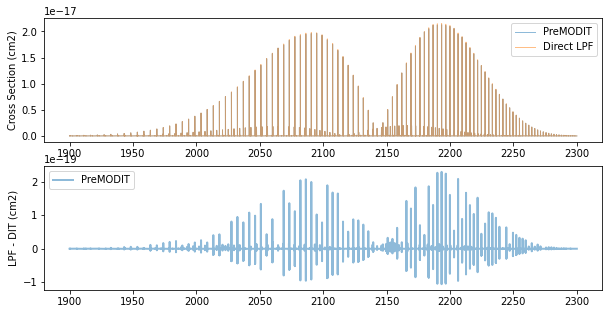

In [18]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(211)
plt.plot(nus,xs,lw=1,alpha=0.5,label="PreMODIT")
plt.plot(nus,xsv,lw=1,alpha=0.5,label="Direct LPF")
plt.legend(loc="upper right")
plt.ylabel("Cross Section (cm2)")
ax=fig.add_subplot(212)
plt.plot(nus,xsv-xs,lw=2,alpha=0.5,label="PreMODIT")
plt.ylabel("LPF - DIT (cm2)")
plt.legend(loc="upper left")
plt.show()

There is about 1 % deviation between LPF and PreMODIT. 

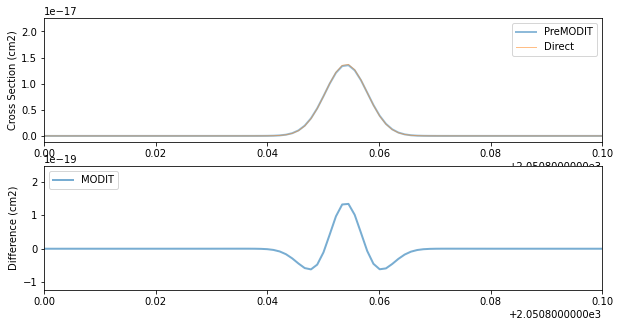

In [17]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(211)
plt.plot(nus,xs,lw=2,alpha=0.5,label="PreMODIT")
plt.plot(nus,xsv,lw=1,alpha=0.5,label="Direct")
plt.legend(loc="upper right")
plt.xlim(2050.8,2050.9)
plt.ylabel("Cross Section (cm2)")
ax=fig.add_subplot(212)
plt.plot(nus,xsv-xs,lw=2,alpha=0.6,label="MODIT")
plt.legend(loc="upper left")
plt.ylabel("Difference (cm2)")
plt.xlim(2050.8,2050.9)
#plt.yscale("log")
plt.savefig("fine_grid.png")